In [1]:
from smart_open import open
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

# Load data for attackers

In [2]:
data = pd.read_csv("../data/training_pruned_file_20162021.csv")

In [3]:
players = data.loc[lambda x: x["position"] == "Attack"]

In [4]:
sorted(players.columns.values)

['accurate_crosses.total',
 'accurate_passes.total',
 'aerials_won.total',
 'agent_name',
 'bench.total',
 'big_chances_created.total',
 'big_chances_missed.total',
 'birth.country',
 'blocked_shots.total',
 'captain.total',
 'cards.red',
 'cards.yellow',
 'cards.yellowred',
 'clearances.total',
 'common_name',
 'continent',
 'country_name',
 'date',
 'date_of_birth',
 'dispossessed.total',
 'dribbled_past.total',
 'dribbles.attempts',
 'dribbles.past',
 'dribbles.success',
 'duels.total',
 'duels.won',
 'duels_won.total',
 'error_lead_to_goal.total',
 'firstname_x',
 'foot',
 'fouls.committed',
 'fouls.drawn',
 'fouls.total',
 'fouls_drawn.total',
 'games.appearences',
 'games.captain',
 'games.lineups',
 'games.minutes',
 'games.number',
 'games.position',
 'games.rating',
 'gender',
 'global_performance',
 'goals.assists',
 'goals.conceded',
 'goals.goals',
 'goals.penalties',
 'goals.saves',
 'goals.total_y',
 'height_x',
 'highest_market_value_in_eur',
 'hit_woodwork.total',
 'int

## Select variables

In [5]:
players_selected_vars = players[[
    "name",
    "player_id_api",
    "date_of_birth",
    "nationality",
    "team_name",
    'league_name',
     'league.season',
    # "error_lead_to_goal.total",
    # "saves_inside_box.total",
    "games.appearences",
    "games.lineups",
    "games.minutes",
    # "goals.conceded",
    # "goals.saves",
    # "penalty.saved",
    # "highest_market_value_in_eur",
    "market_value_in_eur_x",
    # "own_goals.total",
    "accurate_crosses.total",
    "big_chances_created.total",
    "big_chances_missed.total",
    "blocked_shots.total",
    "dribbled_past.total",
    "goals.goals",
    "offsides.total",
    "shots_off_target.total",
    "through_balls.total",
    "total_crosses.total",
    "shots.total",
    "shots.on",
    "goals.total_y",
    "goals.assists",
    "passes.key",
    "dribbles.attempts",
    "dribbles.success",
    "dribbles.past",
]].copy().rename({
    "team_name": "team",
    "league_name": "league",
    "league.season": "season",
    "games.appearences": "matches_played",
    "games.lineups": "matches_started",
    "games.minutes": "minutes",
    # "goals.conceded": "goals_against",
    # "goals.saves": "saves",
    # "saves_inside_box.total": "saves_inside_box",
    # "penalty.saved": "penalty_kicks_saves",
    # "own_goals.total": "own_goals_against",
    # "error_lead_to_goal.total": "errors_to_goal",
    "market_value_in_eur_x": "market_value",
}, axis=1)
players_selected_vars["90s_played"] = players_selected_vars["minutes"] / 90
# players_selected_vars["goals_against_90s"] = players_selected_vars["goals_against"] / players_selected_vars["90s_played"]
# players_selected_vars["shots_on_target_against"] = players_selected_vars["goals_against"] + players_selected_vars["saves"]
# players_selected_vars["save%"] = players_selected_vars["saves"] / players_selected_vars["shots_on_target_against"]
players_selected_vars["age"] = pd.to_datetime(players_selected_vars["date_of_birth"]).map(lambda x: int((pd.Timestamp.today() - x).days / 365))
# players_selected_vars["own_goals_against"] = players_selected_vars["own_goals_against"].fillna(0)
for per_90 in [
    # "shots_on_target_against",
    # "saves_inside_box",
    # "saves",
    # "penalty_kicks_saves",
    # "own_goals_against",
    # "goals_against",
    # "accurate_crosses.total",
    # "big_chances_created.total",
    # "big_chances_missed.total",
    # "blocked_shots.total",
    # "dribbled_past.total",
    # "goals.goals",
    # "offsides.total",
    # "shots_off_target.total",
    # "through_balls.total",
    # "total_crosses.total",
    # "shots.total",
    # "shots.on",
    # "goals.total_y",
    # "goals.assists",
    # "passes.key",
    # "dribbles.attempts",
    # "dribbles.success",
    # "dribbles.past",
]:
    players_selected_vars[per_90] = players_selected_vars[per_90] / players_selected_vars["90s_played"]


players_selected_vars.replace([np.inf, -np.inf], np.nan, inplace=True)
    
players_selected_vars = players_selected_vars.drop([
    "date_of_birth",
    "minutes",
], axis=1)

order = [
    "name",
    "player_id_api",
    "age",
    "nationality",
    "league",
    "team",
    "season",
    "matches_played",
    "matches_started",
    # "minutes",
    "90s_played",
    # "goals_against",
    # "own_goals_against",
    # "shots_on_target_against",
    # "saves",
    # "save%",
    # "saves_inside_box",
    # "penalty_kicks_saves",
    "market_value",
    "accurate_crosses.total",
    "big_chances_created.total",
    "big_chances_missed.total",
    "blocked_shots.total",
    "dribbled_past.total",
    "goals.goals",
    "offsides.total",
    "shots_off_target.total",
    "through_balls.total",
    "total_crosses.total",
    "shots.total",
    "shots.on",
    "goals.total_y",
    "goals.assists",
    "passes.key",
    "dribbles.attempts",
    "dribbles.success",
    "dribbles.past",
]
players_selected_vars = players_selected_vars[order + list(set(players_selected_vars.columns).difference(order))]
players_selected_vars

,name,player_id_api,age,nationality,league,team,season,matches_played,matches_started,90s_played,...,through_balls.total,total_crosses.total,shots.total,shots.on,goals.total_y,goals.assists,passes.key,dribbles.attempts,dribbles.success,dribbles.past
0,George Thomas,20479,26,Wales,Premier League,Leicester City,2017,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,Kelechi Promise Iheanacho,2778,26,Nigeria,Premier League,Leicester City,2017,21.0,7.0,9.144444,...,NaN,5.0,29.0,11.0,3.0,3.0,11.0,18.0,13.0,NaN
6,Demarai Gray,18781,26,England,Premier League,Leicester City,2017,35.0,17.0,18.777778,...,NaN,86.0,36.0,9.0,3.0,1.0,29.0,63.0,38.0,NaN
7,Riyad Mahrez,635,32,Algeria,Premier League,Leicester City,2017,36.0,34.0,32.888889,...,NaN,157.0,73.0,36.0,12.0,10.0,59.0,157.0,80.0,NaN
9,Shinji Okazaki,18787,37,Japan,Premier League,Leicester City,2017,27.0,17.0,14.766667,...,NaN,6.0,28.0,16.0,6.0,2.0,15.0,38.0,16.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14762,Johann Berg Guðmunds­son,2790,32,Iceland,Premier League,Burnley,2021,18.0,13.0,12.277778,...,NaN,44.0,12.0,5.0,0.0,1.0,7.0,22.0,14.0,NaN
14765,Dwight McNeil,18929,23,England,Premier League,Burnley,2021,38.0,35.0,34.600000,...,NaN,199.0,32.0,15.0,0.0,1.0,49.0,150.0,90.0,NaN
14768,Matěj Vydra,18930,31,Czech Republic,Premier League,Burnley,2021,22.0,5.0,7.400000,...,NaN,2.0,15.0,7.0,2.0,3.0,6.0,14.0,6.0,NaN
14770,Ashley Barnes,18927,33,England,Premier League,Burnley,2021,23.0,8.0,8.888889,...,NaN,2.0,14.0,6.0,1.0,NaN,8.0,8.0,5.0,NaN


In [6]:
team_tiers = {
    'Leicester City': "3", 
    'Stoke City': "-1", 
    'West Bromwich Albion': "-1",
    'Amiens SC': "-1", 
    'Strasbourg': "3", 
    'Hamburger SV': "-1", 
    'SC Freiburg': "4",
    'Hannover 96': "-1", 
    'VfL Wolfsburg': "2",
    'Bayer 04 Leverkusen': "1",
       'Borussia Dortmund': "1", 
    'FC Bayern München': "1", 
    'RB Leipzig': "2", 
    'Sassuolo': "3",
       'Fiorentina': "3", 
    'Watford': "-1", 
    'Deportivo La Coruña': "-1", 
    'Celta de Vigo': "4",
       'Levante': "-1", 
    'VfB Stuttgart': "5", 
    'Real Betis': "3",
    'Girona': "5",
       'AFC Bournemouth': "6", 
    'Crystal Palace': "5", 
    'Liverpool': "1", 
    'Chelsea': "1",
       'Newcastle United': "4", 
    'Southampton': "4", 
    'Manchester City': "1",
       'Huddersfield Town': "-1", 
    'Brighton & Hove Albion': "6", 
    'Swansea City': "-1",
       'Rennes': "2", 
    'Saint-Étienne': "-1", 
    'Troyes': "6", 
    'FC Köln': "-1",
       'Borussia Mönchengladbach': "3", 
    'FSV Mainz 05': "4", 
    'Hertha BSC': "3",
       'Manchester United': "2", 
    'Dijon': "-1", 
    'Monaco': "1", 
    'Benevento': "-1", 
    'FC Augsburg': "4",
       'Caen': "-1", 
    'Sevilla': "2", 
    'Málaga': "-1", 
    'Angers SCO': "6", 
    'Deportivo Alavés': "-1",
       'Montpellier': "3",
    'Werder Bremen': "6", 
    'Cagliari': "-1", 
    'Athletic Club': "3",
       'Bologna': "-1", 
    'Genoa': "-1",
    'Hellas Verona': "6",
    'Nantes': "4", 
    'Nice': "3",
       'Olympique Lyonnais': "-1",
    'Metz': "-1", 
    'Paris Saint Germain': "1",
    'Leganés': "-1",
       'Las Palmas': "-1", 
    'Everton': "3",
    'Udinese': "4", 
    'Bordeaux': "-1", 
    'Sampdoria': "4",
       'Inter': "2",
    'Tottenham Hotspur': "2",
    'Arsenal': "2",
    'Lazio': "2",
       'West Ham United': "3",
    'Burnley': "-1", 
    'Roma':"1",
    'Torino': "3",
    'FC Barcelona': "1",
       'Olympique Marseille':"2",
    'Real Sociedad': "3",
    'Villarreal': "2",
       'Atlético Madrid':"3",
    'SD Eibar': "-1", 
    'Real Madrid': "1",
    'Getafe': "3",
    'Crotone': "-1",
       'Espanyol': "4", 
    'Valencia': "2",
    'Schalke 04': "2",
    'Guingamp': "-1", 
    'Lille': "-1",
       'Toulouse': "5",
    'Eintracht Frankfurt': "-1",
    'TSG Hoffenheim': "3",
    'Milan': "2",
       'Juventus':"1",
    'Napoli':"1",
    'SPAL': "-1", 
    'Atalanta': "3",
    'Chievo': "-1",
    'Cardiff City': "-1",
       'Wolverhampton Wanderers': "-1", 
    'Frosinone': "-1", 
    'Flamengo': "-1", 
    'Empoli': "5",
       'Reims': "3",
    'Rayo Vallecano': "5",
    'Nîmes': "-1", 
    'Fulham': "5", 
    'Fortuna Düsseldorf': "-1",
       'Nürnberg': "-1", 
    'Huesca': "-1",
    'Parma': "-1",
    'Corinthians': "-1", 
    'Real Valladolid': "6",
       'Brescia': "-1",
    'Lecce': "6", 
    'Paderborn': "-1", 
    'FC Union Berlin': "3",
    'Granada': "-1",
       'Norwich City': "-1",
    'Osasuna': "4",
    'Mallorca': "5",
    'Brest': "6",
    'Palmeiras': "-1",
       'Santos': "-1", 
    'Sheffield United': "-1",
    'Fluminense': "-1",
    'Aston Villa': "4",
       'Leeds United': "5",
    'Elche': "6",
    'Cádiz': "6",
    'Lorient': "5",
       'DSC Arminia Bielefeld': "-1", 
    'Spezia': "6",
    'Lens': "4",
    'Botafogo': "-1", 
    'Brentford': "6",
       'Internacional': "-1",
    'VfL Bochum 1848': "6",
    'Venezia': "-1", 
    'Clermont': "4",
       'Salernitana': "5",
    'Sport Recife': "-1",
    'SpVgg Greuther Fürth': "-1"
}

In [7]:
players_selected_vars = pd.merge(players_selected_vars, pd.Series(team_tiers, name="tier"), left_on="team", right_index=True)

In [8]:
mvs = players_selected_vars["market_value"].values
mvs = np.expand_dims(mvs, axis=1)
mvs = normalize(mvs, norm="max", axis=0)
mvs = np.squeeze(mvs)
players_selected_vars["normalised_market_value"] = mvs

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## Transformation pipeline

In [10]:
numeric_features = [
    "age",
    "matches_played",
    "matches_started",
    "90s_played",
    # "goals_against",
    # "own_goals_against",
    # "shots_on_target_against",
    # "saves",
    # "save%",
    # "saves_inside_box",
    # "penalty_kicks_saves",
    "accurate_crosses.total",
    "big_chances_created.total",
    "big_chances_missed.total",
    "blocked_shots.total",
    "dribbled_past.total",
    "goals.goals",
    "offsides.total",
    "shots_off_target.total",
    "through_balls.total",
    "total_crosses.total",
    "shots.total",
    "shots.on",
    "goals.total_y",
    "goals.assists",
    "passes.key",
    "dribbles.attempts",
    "dribbles.success",
    "dribbles.past",
]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_features = [
    "nationality",
    "league",
    "team",
    "tier",
]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Predict price bucket

In [62]:
bins = [
    0.0025,
    0.005,
    0.01,
    0.025,
    0.05,
    0.1,
    0.25,
    0.5,
    1.0
]
y = np.digitize(players_selected_vars["normalised_market_value"], bins)
X = players_selected_vars

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([376, 297, 498, 883, 576, 530, 471, 148,  41,   1]))

In [65]:
random = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DummyClassifier(strategy="stratified")),
    ]
)
random.fit(X_train, y_train)

y_random = random.predict(X_test)

balanced_accuracy_score(y_test, y_random)

0.10356716240387413

In [66]:
np.unique(y_random, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 96,  82, 123, 218, 149, 112, 133,  34,   9]))

In [67]:
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", LogisticRegression()),
    ]
)
clf.fit(X_train, y_train)

y_lr = clf.predict(X_test)

balanced_accuracy_score(y_test, y_lr)

/Users/jwasilewski/Library/Caches/pypoetry/virtualenvs/models-wTMcHaj6-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.3735365836514086

In [68]:
np.unique(y_test - y_lr, return_counts=True)

(array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6]),
 array([  1,   5,   7,  19,  43, 189, 392, 187,  71,  27,  10,   2,   3]))

In [69]:
np.unique(y_lr, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([127,  39, 110, 251, 130, 140, 127,  26,   6]))

In [75]:
from sklearn.neural_network import MLPClassifier

mlp = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 8, 4))),
    ]
)
mlp.fit(X_train, y_train)

y_mlp = mlp.predict(X_test)

balanced_accuracy_score(y_test, y_mlp)

/Users/jwasilewski/Library/Caches/pypoetry/virtualenvs/models-wTMcHaj6-py3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.46364422373853376

## Features importance

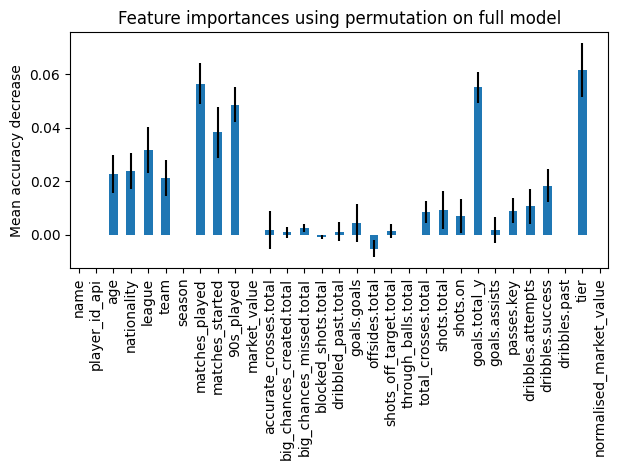

In [15]:
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Predict market value

In [46]:
def r2_adj(model, x,y):
    r2 = model.score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    return 1-(1-r2)*(n-1)/(n-p-1)

In [57]:
X = players_selected_vars
# y = players_selected_vars["normalised_market_value"]
y = np.log(players_selected_vars["market_value"])

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
random_regression = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regression", DummyRegressor()),
    ]
)
random_regression.fit(X_train, y_train)

random_regression.score(X_test, y_test), r2_adj(random_regression, X_test, y_test)

(-0.0003449898554093167, -0.03390634774016865)

In [60]:
regression = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regression", LinearRegression()),
    ]
)
regression.fit(X_train, y_train)

regression.score(X_test, y_test), r2_adj(regression, X_test, y_test)

(0.634152343837121, 0.6218782341606608)

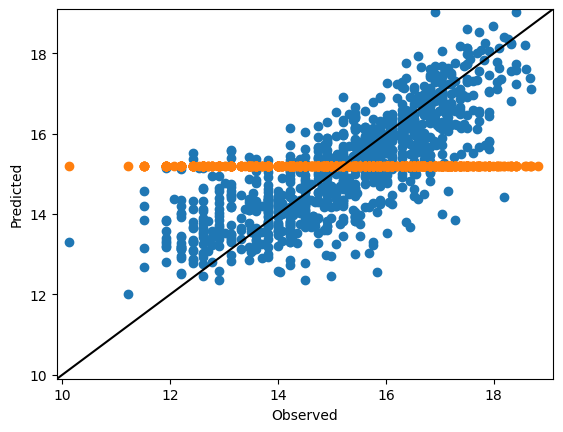

In [61]:
plt.scatter(y_test, regression.predict(X_test))
plt.scatter(y_test, random_regression.predict(X_test))
plt.axline((0, 0), (1, 1), c="k")
plt.xlim(np.floor(y_test.min())-0.1, np.ceil(y_test.max())+0.1)
plt.ylim(np.floor(y_test.min())-0.1, np.ceil(y_test.max())+0.1)
plt.xlabel("Observed")
plt.ylabel("Predicted")
_ = plt.show()

## Features importance

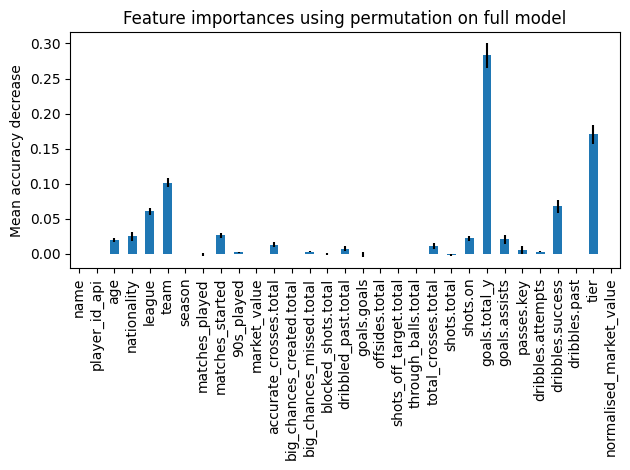

In [22]:
result = permutation_importance(
    regression, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Predict change in market value between seasons

In [23]:
before_after_seasons = pd.merge(
    players_selected_vars, 
    players_selected_vars, 
    on="player_id_api", 
    suffixes=["_before", "_after"]
).query("season_after - season_before == 1")

In [24]:
numeric_features_ba = [
    f"{c}_{suffix}" for c in [
        "age",
        "matches_played",
        "matches_started",
        "90s_played",
        # "goals_against",
        # "own_goals_against",
        # "shots_on_target_against",
        # "saves",
        # "save%",
        # "saves_inside_box",
        # "penalty_kicks_saves",
        "accurate_crosses.total",
        "big_chances_created.total",
        "big_chances_missed.total",
        "blocked_shots.total",
        "dribbled_past.total",
        "goals.goals",
        "offsides.total",
        "shots_off_target.total",
        "through_balls.total",
        "total_crosses.total",
        "shots.total",
        "shots.on",
        "goals.total_y",
        "goals.assists",
        "passes.key",
        "dribbles.attempts",
        "dribbles.success",
        "dribbles.past",
    ]
    for suffix in ["before","after"]
]
numeric_transformer_ba = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_features_ba = [
    f"{c}_{suffix}" for c in [
        "nationality",
        "league",
        "team",
        "tier",
    ]
    for suffix in ["before","after"]
]
categorical_transformer_ba = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor_ba = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_ba, numeric_features_ba),
        ("cat", categorical_transformer_ba, categorical_features_ba),
    ]
)

In [25]:
X = before_after_seasons
y_before = np.digitize(before_after_seasons["normalised_market_value_before"], bins)
y_after = np.digitize(before_after_seasons["normalised_market_value_after"], bins)
y = np.minimum(np.maximum(y_after - y_before, -1), 1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
random = Pipeline(
    steps=[
        ("preprocessor", preprocessor_ba),
        ("classifier", DummyClassifier(strategy="stratified")),
    ]
)
random.fit(X_train, y_train)

balanced_accuracy_score(y_test, random.predict(X_test))

0.32217692117617985

In [28]:
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor_ba), 
        ("classifier", LogisticRegression()),
    ]
)
clf.fit(X_train, y_train)

print(confusion_matrix(y_test, clf.predict(X_test), labels=[1, 0, -1]))

balanced_accuracy_score(y_test, clf.predict(X_test))

[[ 35  52   8]
 [ 18 193  73]
 [  7 106  77]]


/Users/jwasilewski/Library/Caches/pypoetry/virtualenvs/models-wTMcHaj6-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.4844205584383494

## Features importance

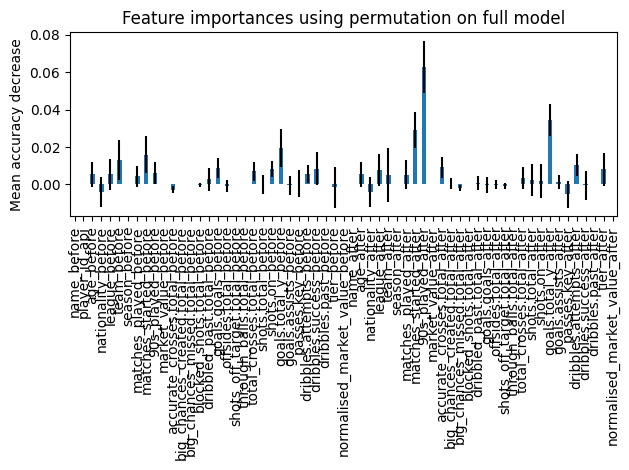

In [29]:
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()